####Copyright https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans

In [ ]:
#Importing some usefull libraries
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
%matplotlib inline

In [ ]:
#Download the dataset
dataset = MNIST(root='data/', download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
len(dataset)

60000

image.shape: torch.Size([1, 28, 28])
label 5


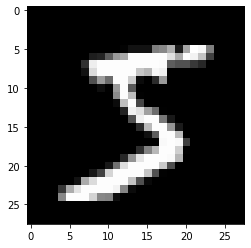

In [ ]:
#Print one of the image
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('label', label)

In [ ]:
#Spliting the dataset into training and validation 
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
#Converting the data into batches
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
train_loader, val_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f806f2e2990>,
 <torch.utils.data.dataloader.DataLoader at 0x7f806f2e2450>)

images.shape torch.Size([128, 1, 28, 28])


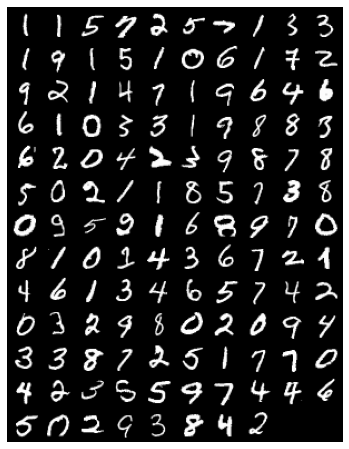

In [ ]:
#Visulizing batch of data into grid
for images, _ in train_loader:
  print('images.shape', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=10).permute(1,2,0))
  break


In [ ]:
#Reshaping the input data to the 2 dimentional vector to pass to model
for images, labels in train_loader:
  print('images.shape:', images.shape)
  inputs = images.reshape(-1,784)
  print('inputs.shape:', inputs.shape)
  break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [ ]:
input_size = inputs.shape[-1]
hidden_size = 32

In [ ]:
layer1 = nn.Linear(input_size, hidden_size)

In [ ]:
inputs.shape

torch.Size([128, 784])

In [ ]:
layer1_output = layer1(inputs)
print('layer1 output.shape:', layer1_output.shape)

layer1 output.shape: torch.Size([128, 32])


In [ ]:
#Direct way to see the hidden layer manupulation
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [ ]:
torch.allclose(layer1_output, layer1_outputs_direct, 1e-3)

True

In [ ]:
#Checking reLU function
F.relu(torch.tensor([[1, 5, -6], [-4, -6, 0]]))

tensor([[1, 5, 0],
        [0, 0, 0]])

In [ ]:
relu_outputs = F.relu(layer1_output)
print('min layer1_output: ', torch.min(layer1_output).item())
print('min relu_outputs: ', torch.min(relu_outputs).item())

min layer1_output:  -0.6632679104804993
min relu_outputs:  0.0


In [ ]:
#Inserting second layer
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)
layer2_outputs = layer2(relu_outputs)
print("layer2 output: ", layer2_outputs.shape)
inputs.shape

layer2 output:  torch.Size([128, 10])


torch.Size([128, 784])

In [ ]:
#Compute the loss
F.cross_entropy(layer2_outputs, labels)

tensor(2.3015, grad_fn=<NllLossBackward0>)

In [ ]:

#Defining the model
class MinistModel(nn.Module):
  def __init__(self, in_size, hidden_size,  out_size):
    super().__init__()
    #First layer
    self.linear1 = nn.Linear(in_size, hidden_size)
    #Output layer
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    #Flatten the input layer
    xb = xb.view(xb.size(0),-1)
    #Get intermidiate output using hidden layer
    out = self.linear1(xb)
    #Apply activation function
    out = F.relu(out)
    #Get predictions using output layers
    out = self.linear2(out)
    return out
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss, 'val_acc': acc}
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  def epoch_end(self, epoch, result):
    print("Epoch[{}], val_loss:{:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))



In [ ]:
#Accuracy function
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item() / len(preds))

In [ ]:
input_size = 784 
hidden_size = 32
num_classes = 10

In [ ]:
model = MinistModel(input_size, hidden_size, out_size=num_classes)

In [ ]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
#Generate some outputs using the model
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss:', loss.item())
  break
  


Loss: 2.2912466526031494


#Adding GPU

In [ ]:
#check GPU is available
torch.cuda.is_available()

False

In [ ]:
#Get default device
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
#Move the data to the device
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return(to_device(x, device) for x in data)
  return data.to(device, non_blocking=True)

In [ ]:
#Check if data going well to gpu
for images, labels in train_loader:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cpu


In [ ]:
 #Device dataloader to load the batche of data to the selected device
 class deviceDataLoader():
   def __init__(self, dl, device):
     self.dl = dl
     self.device = device
   def __iter__(self):
      for b in self.dl:
        yield to_device(b, device)
   def __len__(self):
      return len(self.dl)

In [ ]:
#Load the batches of data to the available or selected device
train_loader = deviceDataLoader(train_loader, device)
val_loader = deviceDataLoader(val_loader, device)

In [ ]:
#Check the data loaded to selected device well or not
for xb, yb in val_loader:
  print('xb.deive:', xb.device)
  print('yb: ', yb)
  break

xb.deive: cpu
yb:  tensor([0, 4, 9, 4, 4, 8, 9, 8, 6, 5, 3, 1, 9, 6, 1, 4, 2, 9, 0, 7, 2, 4, 0, 1,
        0, 3, 4, 4, 3, 1, 5, 0, 2, 7, 2, 4, 7, 1, 5, 5, 3, 3, 3, 2, 3, 0, 9, 4,
        4, 6, 8, 4, 1, 8, 5, 4, 4, 7, 1, 4, 9, 5, 9, 4, 6, 3, 1, 8, 4, 3, 9, 1,
        7, 5, 7, 3, 7, 3, 1, 4, 5, 6, 1, 3, 4, 9, 0, 7, 3, 3, 0, 4, 9, 5, 1, 1,
        0, 9, 1, 6, 0, 2, 4, 5, 8, 7, 3, 0, 2, 2, 2, 7, 6, 9, 7, 0, 1, 5, 2, 7,
        2, 1, 4, 7, 7, 7, 4, 9])


#Training the model

In [ ]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_step(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):

  history = []
  optimizer = opt_func(model.parameters(), lr)

  for epoch in range(epochs):
    #Training step
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #Validation step
    result = model.validation_step(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
model = MinistModel(input_size, hidden_size, out_size=num_classes)

In [ ]:
#Sending to device
to_device(model, device)

MinistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:

history = [evaluate(model, val_loader)]

TypeError: ignored